실행환경!!
- Python 3.8.10
- Pytorch 2.0.1
- torchvision 0.15.2

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
from torch.utils.data import DataLoader

In [2]:
## 데이터 로더로 CIFAR-10 불러오기
def get_dataloaders(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data2', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data2', train=False, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, testloader

In [3]:
## 랜덤으로 아키텍쳐 조합하기
class RandomNet(nn.Module):
    def __init__(self, num_layers, num_units, activation):
        super(RandomNet, self).__init__()
        layers = []
        in_features = 32 * 32 * 3  # CIFAR-10 input size
        for _ in range(num_layers):
            layers.append(nn.Linear(in_features, num_units))
            layers.append(activation())
            in_features = num_units
        layers.append(nn.Linear(num_units, 10))  # Output layer
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.model(x)

In [4]:
## 앞에서 불러온 모델을 직접 학습하기
def train_model(model, trainloader, testloader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")
    
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [5]:
## 랜덤 서치 NAS 알고리즘 구현!!
def random_search(num_trials=10):
    best_model = None
    best_accuracy = 0
    best_params = None
    trainloader, testloader = get_dataloaders()
    
    for trial in range(num_trials):
        num_layers = random.randint(1, 5)
        num_units = random.choice([64, 128, 256, 512])
        activation = random.choice([nn.ReLU, nn.Tanh, nn.LeakyReLU])
        
        print(f"Trial {trial+1}: num_layers={num_layers}, num_units={num_units}, activation={activation.__name__}")
        model = RandomNet(num_layers, num_units, activation)
        accuracy = train_model(model, trainloader, testloader)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_params = (num_layers, num_units, activation)
    
    print(f"Best Model: num_layers={best_params[0]}, num_units={best_params[1]}, activation={best_params[2].__name__}")
    print(f"Best Accuracy: {best_accuracy:.2f}%")
    return best_model

In [6]:
if __name__ == "__main__":
    best_model = random_search()

100%|██████████| 170498071/170498071 [00:44<00:00, 3826519.60it/s]


Extracting ./data2/cifar-10-python.tar.gz to ./data2
Files already downloaded and verified
Trial 1: num_layers=4, num_units=128, activation=LeakyReLU
Epoch 1, Loss: 1.7121
Epoch 2, Loss: 1.4739
Epoch 3, Loss: 1.3657
Epoch 4, Loss: 1.2811
Epoch 5, Loss: 1.2105
Test Accuracy: 52.54%
Trial 2: num_layers=4, num_units=256, activation=Tanh
Epoch 1, Loss: 1.7739
Epoch 2, Loss: 1.6162
Epoch 3, Loss: 1.5274
Epoch 4, Loss: 1.4552
Epoch 5, Loss: 1.4000
Test Accuracy: 48.11%
Trial 3: num_layers=5, num_units=256, activation=ReLU
Epoch 1, Loss: 1.7212
Epoch 2, Loss: 1.4831
Epoch 3, Loss: 1.3566
Epoch 4, Loss: 1.2602
Epoch 5, Loss: 1.1787
Test Accuracy: 52.58%
Trial 4: num_layers=3, num_units=128, activation=Tanh
Epoch 1, Loss: 1.7636
Epoch 2, Loss: 1.6167
Epoch 3, Loss: 1.5424
Epoch 4, Loss: 1.4797
Epoch 5, Loss: 1.4272
Test Accuracy: 46.84%
Trial 5: num_layers=4, num_units=64, activation=LeakyReLU
Epoch 1, Loss: 1.7431
Epoch 2, Loss: 1.5098
Epoch 3, Loss: 1.4153
Epoch 4, Loss: 1.3465
Epoch 5, Loss:

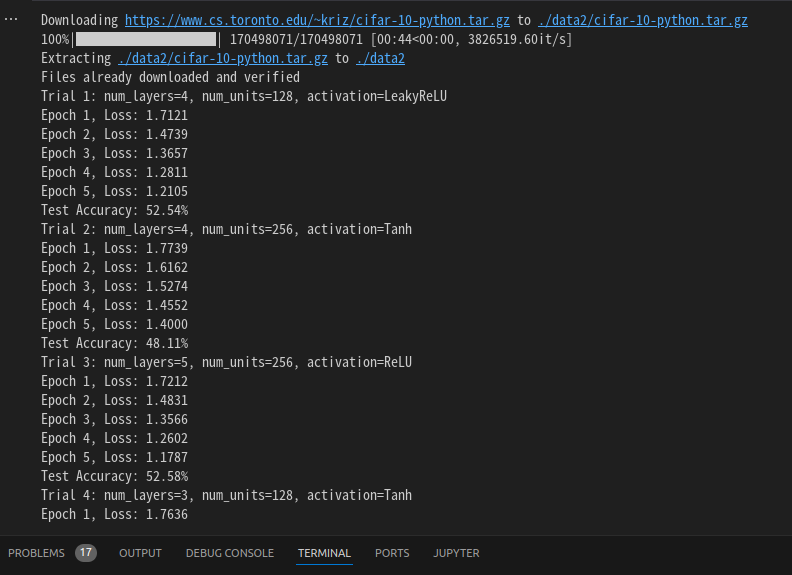